<a href="https://colab.research.google.com/github/ViralTexts/viral-texts-classification/blob/workshop/RecipeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genre Classification

Last week we worked in Python, today we will work in R. This isn't for any deep, philosophical reasons. Instead, I learned to do this work in R and it's where I still feel most comfortable coding. Like last week, you don't have to know how to write any of this code to work through the lab, but there are places where you can adjust and adapt if you are comfortable doing so. Following [our reading from Ben Schmidt](https://dhdebates.gc.cuny.edu/read/untitled/section/557c453b-4abb-48ce-8c38-a77e24d3f0bd#ch48) today, we will focus on understanding the _transformations_ of our data at each stage of this process rather than trying to understand the nitty-gritty of each algorithm in use. 

The workflow in this notebook is adapted from [Julia Silge's tutorial on authorship classification](https://www.r-bloggers.com/2018/12/text-classification-with-tidy-data-principles/).


In [ ]:
install.packages("tidytext")

library(tidyverse)
library(tidytext)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘SnowballC’, ‘hunspell’, ‘janeaustenr’, ‘tokenizers’


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
unclassified <- read_csv("https://github.com/ViralTexts/viral-texts-classification/blob/workshop/data/part-00000-b4557c14-339a-4d3b-8422-05d1babf9abc-c000.csv?raw=true") %>%
  select(cluster, text) %>%
  mutate(cluster = as.character(cluster)) %>%
  rename(doc_id = cluster) %>%
  distinct(doc_id, .keep_all = TRUE) %>%
  mutate(genre = "unknown")

ERROR: ignored

In [ ]:
head(unclassified)

doc_id      
1 942080      
2 60130666966 
3 171799931797
4 17181171824 
5 1307955     
6 1503996     
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## Why Classify Genres?

_Viral Texts_ RA Avery Blankenship wrote more about why she assembled this corpus of nineteenth-century receipes in this blog post, which also links to the text files if you want to read some of them: <https://viraltexts.org/2021/02/24/c19-recipes/>. What this post helps us understand is one use case for genre classification, which is when you have an enormous dataset and want to find one specific kind of material within it. Avery want to write about how culinary texts circulated in historical newspapers, but our data comprises millions of individual reprints. In order to find those she's interested in, we need a way to identify those reprints that are likely to be about culinary topics from the larger mass of texts. We could use keyword search to do that, but classification allows to cast a wider, exploratory net. As Avery shows, classification also enables her to find texts that are structured like recipes but aren't really about food, which gives insight into the broader uses to which the recipe genre was put during the period.

In [ ]:
classified <- read_csv("https://github.com/ViralTexts/viral-texts-classification/raw/workshop/hand-tagged/recipes.csv?raw=true")

head(classified)

Rows: 1034 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): doc_id, text, genre

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


doc_id,text,genre
<chr>,<chr>,<chr>
29982_anewmayonnaise.txt,"A NEW MAYONNAISE (Soyer's).--Put a quarter of a pint of stiff veal jelly (that has been nicely flavored with vegetables) on ice in a bowl, whisking it till it is a white froth; then add half a pint of salad oil and six spoonfuls of tarragon vinegar, _by degrees_, first oil, then vinegar, continually whisking till it forms a white, smooth, sauce-like cream; season with half a teaspoonful of salt, a quarter ditto of white pepper, and a very little sugar, whisk it a little more and it is ready. It should be dressed pyramidically over the article it is served with. The advantage of this sauce is that (although more delicate than any other) you may dress it to any height you like, and it will remain so any length of time; if the temperature is cool, it will remain hours without appearing greasy or melting. It is absolutely necessary, however, that it should be prepared on ice.",recipe
29982_anicelittlebreakfastdish.txt,"A NICE LITTLE BREAKFAST DISH IS made thus: Cut two long slices of cold meat and three of bread, buttered thickly, about the same shape and size; season the meat with pepper, salt, and a little finely chopped parsley; or, if it is veal, a little chopped ham; then lay one slice of bread between two of meat, and have the other two slices outside; fasten together with short wooden skewers. If you have a quick oven, put it in; and take care to baste with butter thoroughly, that the bread may be all over crisp and brown. If you can't depend on your oven, fry it in very hot fat as you would crullers; garnish with sprigs of parsley, and serve very hot.",recipe
29982_anothervealandhampie.txt,"ANOTHER VEAL AND HAM PIE, more usual, and probably the ""weal and hammer"" that ""mellered the organ"" of Silas Wegg, was manufactured by Mrs. Boffin from this recipe; it is as follows: Take the thick part of breast of veal, removing all the bones, which put on for gravy, stewing them long and slowly; put a layer of veal, pepper and salt, then a thin sprinkling of ham; if boiled, cut in slices; if raw, cut a slice in dice, which scald before using, then more veal and again ham. If force-meat balls are liked, make some force-meat as for Windsor pie, using if you prefer it chopped hard-boiled eggs in place of chopped meat, and binding into a paste with a raw egg; then make into balls, which drop into the crevices of the pie; boil two or three eggs quite hard, cut each in four and lay them round the sides and over the top, pour in about a gill of gravy, and cover the same as the Windsor pie. In either of these pies the force-meat may be left out, a sweetbread cut up, or mushrooms put in. A chicken pie to eat cold is very fine made in this way.",recipe
29982_baba.txt,"BABA.--One pound of flour; take one quarter of it, and make a sponge with half an ounce of compressed yeast and a little warm water, set it to rise, make a hole in the rest of the flour, add to it ten ounces of butter, three eggs, and a dessert-spoonful of sugar, a little salt, unless your butter salts it enough, which is generally the case. Beat all together well, then add five more eggs, one at a time, that is to say, add one egg and beat well, then another and beat again, and so on until the five are used. When the paste leaves the bowl it is beaten enough, but not before; then add the sponge to it, and a large half ounce of citron chopped, the same of currants, and an ounce and a half of sultana raisins, seedless. Let it rise to twice its size, then bake it in an oven of dark yellow paper heat; the small round babas are an innovation of the pastry-cook to enable him to sell them uncut. But the baba proper should be baked in a large, deep, upright tin, such as a large charlotte russe mold, when they keep for several days fresh, and if they get stale, make delicious fritters, soaked in sherry and dipped in frying batter. In some cases, however, it may be preferred to make them as usually seen at French pastry cook

The line below simply joins the dataframe of `classified` documents to the dataframe of `unclassified` documents so we can analyze the texts in them both.

In [ ]:
texts <- rbind(classified, unclassified)

## Tokenizing the Texts

Now we will `tokenize` all of our texts, which means we will break their paragraphs and sentences into smaller units—in this case individual words. This will allow us to analyze what words appear more often in recipes vs. unclassified texts, and (eventually) to predict whether any of our unclassified newspaper texts are likely to be recipes, or recipe-adjacent. There are a lot of words in this corpus, even as relatively small as it is, so this code may take a minute to run.

In [ ]:
tidy_texts <- texts %>%
  unnest_tokens(word, text) %>%
  group_by(word) %>%
  filter(n() > 10) %>%
  ungroup()

head(tidy_texts)

doc_id,genre,word
<chr>,<chr>,<chr>
29982_anewmayonnaise.txt,recipe,a
29982_anewmayonnaise.txt,recipe,new
29982_anewmayonnaise.txt,recipe,put
29982_anewmayonnaise.txt,recipe,a
29982_anewmayonnaise.txt,recipe,quarter
29982_anewmayonnaise.txt,recipe,of




Before we start building our model, we can simply count the words in our corpus to see which words appear most often in our recipes vs. in our unclassified texts.We will first import [a list of stopwords](viral-texts-classification/raw/workshop/data/stopwords.txt?raw=true), which we could adjust if necessary, to filter out of this visualization.

In [ ]:
stopwords <- scan("https://github.com/ViralTexts/viral-texts-classification/raw/workshop/data/stopwords.txt?raw=true", what="", sep="\n") %>%
    as_tibble() %>%
    rename(word = 1)

head(stopwords)
class(stopwords)

word
<chr>
a
a's
able
about
above
according


[1] "tbl_df"     "tbl"        "data.frame"

And now we can visualize the top words for each category, `recipes` vs. `unknown.` The code below doesn't permanently transform the data—instead, it temporarily reshapes and visualizes the data for exploratory research. If you tried commenting out the `anti_join` function using `#`, or changed the `top_n` number, you would see different results. 

Joining, by = "word"
Selecting by n


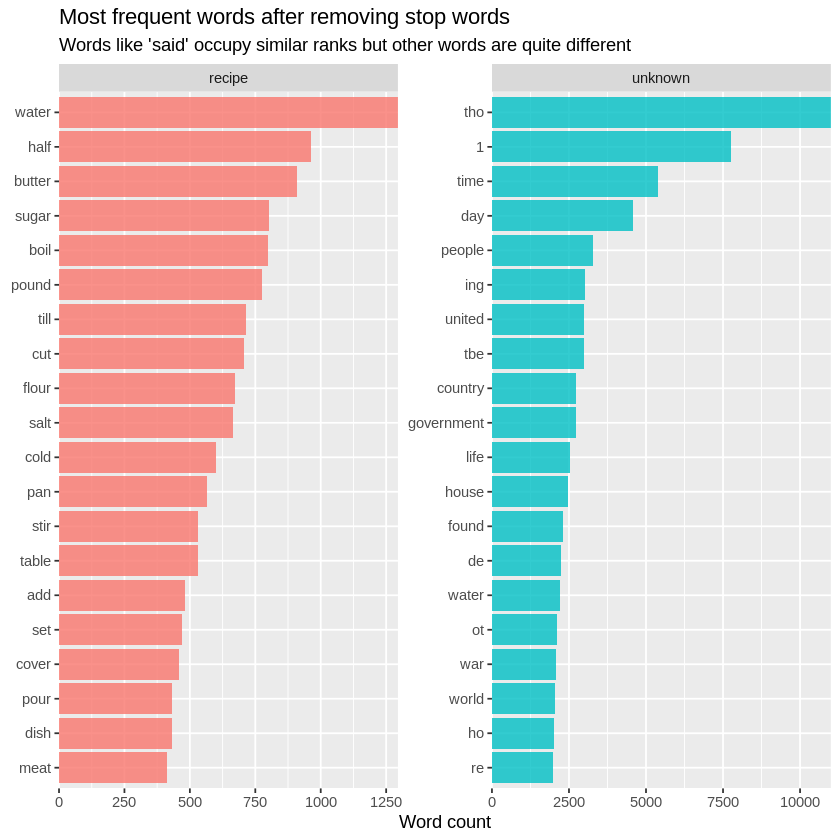

In [ ]:
tidy_texts %>%
  count(genre, word, sort = TRUE) %>%
  anti_join(stopwords) %>%
  group_by(genre) %>%
  top_n(20) %>%
  ungroup() %>%
  ggplot(aes(reorder_within(word, n, genre), n,
             fill = genre
  )) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  scale_x_reordered() +
  coord_flip() +
  facet_wrap(~genre, scales = "free") +
  scale_y_continuous(expand = c(0, 0)) +
  labs(
    x = NULL, y = "Word count",
    title = "Most frequent words after removing stop words",
    subtitle = "Words like 'said' occupy similar ranks but other words are quite different"
  )

You may notice that our `unknown` texts include some words that look like OCR errors, which is because these are clusters of identified reprints from _Chronicling America_, which means they include lots of OCR errors. Some of these likely should be filtered out in our stopwords list, but would not be included in a compiled list because they're not actually English-langauge words. If you want to uncomment the code in this block and rerun it, you will filter out some of those OCR words that should be stopwords. Feel free to add new words in the function, enclosed in parentheses and separated by commas, and then rerun the function above to create new graphs.

In [ ]:
# newstopwords <- c("tho","1","tbh", "de", "ot", "ho", "re") %>%
#     as_tibble() %>%
#     rename(word = value)

# stopwords <- rbind(stopwords,newstopwords) 
# rm(newstopwords)

## Splitting Testing from Training Data

Now we need to create a smaller dataset from a subset of our recipes. This will be our "test data," and once we train our classifier we will use this data to verify that it is reliable. When doing any kind of machine learning research, you typically keep a test data set aside for this kind of verification. Whatever kind of data you are researching—whether images, text, video, or something else—the test data has been tagged by whatever feature you are trying to model, but you treat it as if is not tagged to test how well your model's asssessments line up with human assessments. If we have trained a reliable genre classifier, for example, we would expect it to identify texts we know are recipes as recipes. If it doesn't, then we would now we have more work to do.

In [ ]:
test_data <- sample_n(texts %>%
                        filter(genre == "recipe"), 
                      100, replace = FALSE) %>%
  mutate(genre = "unknown")
train_data <- anti_join(texts, test_data, by="doc_id") %>%
  mutate(genre = "recipe")

In [ ]:
# dim(train_data)
# dim(test_data)
# head(test_data)
# head(train_data)

[1] 10853     3

[1] 100   3

## Into the Matrix

This next step might seem somewhat obscure, but we can unpack it. Essentially, we are going to convert our `dataframe` of word counts into a `matrix`, which is another way to represent the wordcounts we calculated above. In our matrix, each row is a document from our corpus, and each column is an individual word. The values are numeric and reflect the number of times each word appears in each document. As when we tokenized above, this step might take a minute or two since there are lots of words to process.

In [ ]:
sparse_words <- tidy_texts %>%
  count(doc_id, word) %>%
  inner_join(train_data) %>%
  cast_sparse(doc_id, word, n)

dim(sparse_words)


Joining, by = "doc_id"


[1] 10853 18850

The code below doesn't transform anything, but gives us a peek at a section of the matrix so we can understand what this data looks like. If you change the numerical values you'll see a different zone of the full matrix, which has many thousands of rows and columns.

In [ ]:
colnames(sparse_words[,10:29])
sparse_words[1:20, 10:29]

[1] "and"      "apt"      "are"      "aro"      "articles" "as"      
 [7] "asks"     "at"       "be"       "been"     "before"   "begin"   
[13] "bill"     "birthday" "bo"       "boast"    "boiled"   "boots"   
[19] "boston"   "boy"

   [[ suppressing 20 column names ‘and’, ‘apt’, ‘are’ ... ]]



20 x 20 sparse Matrix of class "dgCMatrix"
                                                 
1000442  4 1 1 1 1 3 1  3 5 1 1 1 1 1 2 1 1 1 1 1
1000626  4 . 2 . . 1 .  1 . . . . . . . . . . . .
1000735 33 . . . . 7 .  2 2 2 1 . . . . . . . . .
1000936 11 . . . . 3 .  1 1 1 1 . . . . . . . . .
1003317  3 . . . . . .  2 . 1 . . . . . . . . . .
1003330 13 . 4 . . 1 .  4 1 . . . . . 1 . . . . .
1003960 17 . . . . 1 .  2 5 1 . . . . . . . . . 2
1005163 38 . 7 . . 4 . 10 7 2 1 . 1 . . . . 1 . .
1005372  3 . . . . . .  . . . . . . . 1 . . . . .
1006314  . . . . . . .  . . . . . . . . . . . . .
100899   7 . 1 . . . .  . 2 3 . . . . . . . . . .
1009523  1 . . . . . .  1 . 1 1 . . . . . . . . .
1009531 12 . . . . . .  4 1 3 . . . . . . . . . .
1009737 12 . 3 . . 1 .  3 2 2 . . . . . . . 1 . .
1009779  8 . 1 . . 2 .  1 3 . 2 . . . . . . . . .
101052   1 . . . . . .  . . . . . . . . . . . . .
1011460  5 . 1 . . . .  . . . . . . . . . . . . .
1011644  7 . 1 . . . .  . 3 . . . . . . . . . . .
1012681

In [ ]:
# texts_joined <- rbind(test_data, train_data)
# dim(texts_joined)

[1] 1034    3

Finally, before we build our recipe model, we create a dataframe that connects the data about word counts in the matrix above to the genre tags in the original `texts` data frame. Essentially, this new dataframe says:

> okay, so this document that includes 'rasberry' 5 times and 'mix' 4 times and 'cool' 2 times? That's a recipe. That other document that includes 'president' 5 times, 'congress' 2 times, and 'bill' 3 times? We don't know what genre that is.

In [ ]:
word_rownames <- rownames(sparse_words)
texts_joined <- tibble(doc_id = word_rownames) %>%
  left_join(texts %>%
              select(doc_id, genre))

Joining, by = "doc_id"


In [ ]:
head(texts_joined)

doc_id,genre
<chr>,<chr>
1000442,unknown
1000626,unknown
1000735,unknown
1000936,unknown
1003317,unknown
1003330,unknown


# Building the Model

In order to build our model, we need to install and load the libraries for several R packages designed for just this purpose. This may take a few minutes, as several of these libraries are not installed by default in Google Colab.

In [ ]:
install.packages("glmnet")
install.packages("doMC")
# install.packages("broom")
library(glmnet)
library(doMC)
# library(broom)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-3

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel



ERROR: ignored

## The Algorithmic Bit

This next stage is where we build our model, and is the most mathy—and potential obscure—step in this notebook. For today's class we'll follow Schmidt's argument and not try to unpack the algorithm fully, though you probably should if you continue to use models like this in your work. We still want an idea of the transformation that is happening to our data in this stage, however. We are using a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) which, to oversimplify dramatically by quoting the first sentence of the Wikipedia article, "models the probability of one event (out of two alternatives) taking place." Here the probabilities are pretty simple: our model will look at all the words in the texts labeled `recipe` to calculate the probability that each word belongs to the `receipe` category vs. the `unknown` category. From there, the model can be applied to documents full of words to calculate the probability that X text, comprising Y set of words, belongs to the category `recipe`. 

In [ ]:
registerDoMC(cores = 8)
is_recipe <- texts_joined$genre == "recipe"
model <-  cv.glmnet(sparse_words, is_recipe,
                   family = "binomial",
                   parallel = TRUE, keep = TRUE)

With the model calculated, then, we can see which words are most strongly associated with the model, meaning they have the highest probability of belonging to the tagged category, as well as the words that have a strong negative association with the model. 

In [ ]:
coefs <- model$glmnet.fit %>%
  tidy() %>%
  filter(lambda == model$lambda.1se)

coefs %>%
  arrange(desc(estimate)) %>%
  View()

 # head(coefs)
 # tail(coefs)

term,step,estimate,lambda,dev.ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
raspberry,94,3.6980806,0.001931356,0.922624
pepper,94,1.9793152,0.001931356,0.922624
shred,94,1.8268063,0.001931356,0.922624
filter,94,1.7400191,0.001931356,0.922624
wart,94,1.7271461,0.001931356,0.922624
infuse,94,1.4993368,0.001931356,0.922624
withdrawing,94,1.4961427,0.001931356,0.922624
persevered,94,1.4528924,0.001931356,0.922624
boil,94,1.4261287,0.001931356,0.922624


We can even visualize the ends of the spectrum. Does this spread make sense to you as a human reader of recipes? Are there any suprises that you would want to dig into further? How does this graph change if you start over from the top of the notebook and create a different training and test set?

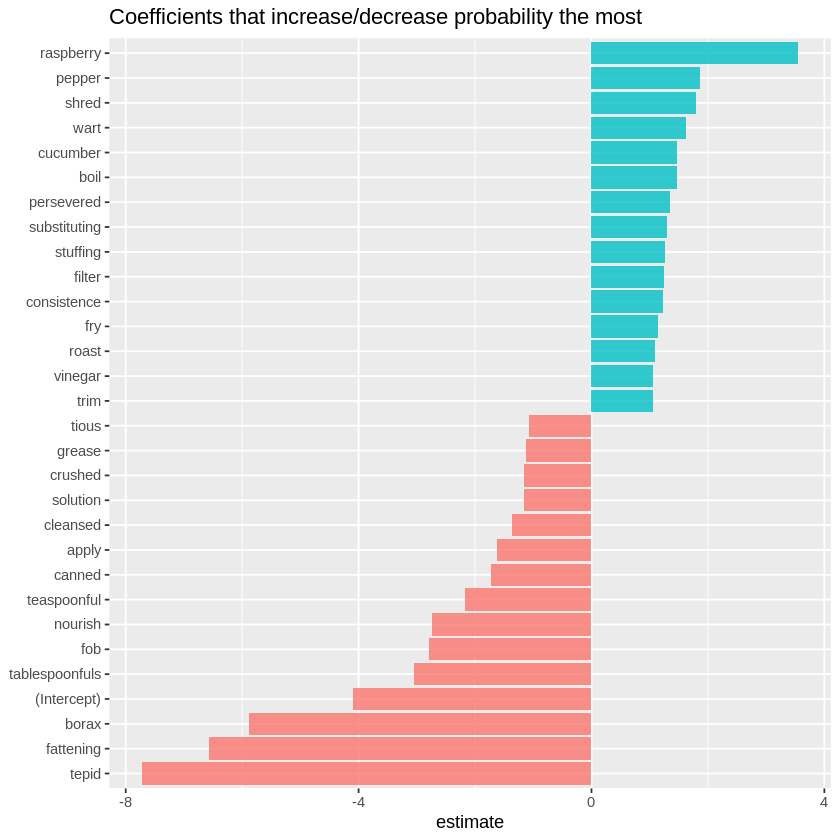

In [ ]:
coefs %>%
  group_by(estimate > 0) %>%
  top_n(15, abs(estimate)) %>%
  ungroup() %>%
  ggplot(aes(fct_reorder(term, estimate), estimate, fill = estimate > 0)) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  coord_flip() +
  labs(
    x = NULL,
    title = "Coefficients that increase/decrease probability the most"
  )

The intercept in a regression model is the expected mean value when the predictor variables—in our case, word counts—are zero. We won't do much with this value in this notebook, but it's important to calculate.

In [ ]:
intercept <- coefs %>%
  filter(term == "(Intercept)") %>%
  pull(estimate)

## Verifying Performance

Now we will make use of that test data we set aside above. We will merge the values for each word in our model with the words in our test data texts, and then use those values to assess the probability that our test data texts are recipes (as we know they are). You will see that even though the model identifies _most_ of our test data as recipes, it does assign a lower probability to some of them. What might that tell us about how the model understands "recipeness?"

In [ ]:
test_eval <- tidy_texts %>%
  inner_join(test_data, by="doc_id") %>%
  inner_join(coefs, by = c("word" = "term")) %>%
  group_by(doc_id) %>%
  summarize(score = sum(estimate)) %>%
  mutate(probability = plogis(intercept + score)) %>%
  left_join(texts %>%
              select(doc_id, text))

test_eval %>%
  arrange(desc(probability)) %>%
  # head(10) %>%
  # tail(10) %>%
  View()

Joining, by = "doc_id"


doc_id,score,probability,text
<chr>,<dbl>,<dbl>,<chr>
9624_toroastapig.txt,24.36847,1.0000000,"TO ROAST A PIG. Begin your preparations by making the stuffing. Take a sufficient quantity of grated stale bread, and mix it with sage and sweet marjoram rubbed fine or powdered; also some grated lemon-peel. Season it with pepper, salt, powdered nutmeg and mace; mix in butter enough to moisten it, and some beaten yolk of egg to bind it. Let the whole be very well incorporated. The pig should be newly killed, (that morning if possible,) nicely cleaned, fat, and not too large. Wash it well in cold water, and cut off the feet close to the joints, leaving some skin all round to fold over the ends. Take out the liver and heart, and reserve them, with the feet, to make the gravy. Truss back the legs. Fill the body with the stuffing (it must be quite full) and then sew it up, or tie it round with a buttered twine. Put the pig on the spit, and place it before a clear brisk fire, but not too near lest it scorch. The fire should be largest at the ends, that the middle of the pig may not be done before the extremities. If you find the heat too great in the centre, you may diminish it by placing a flat-iron before the fire. When you first put it down, wash the pig all over with salt and water; afterwards rub it frequently with a feather dipped in sweet oil, or with fresh butter tied in a rag. If you baste it with any thing else, or with its own dripping, the skin will not be crisp. Take care not to blister or burn the outside by keeping it too near the fire. A good sized pig will require at least three hours’ roasting. Unless a pig is very small it is seldom sent to table whole. Take the spit from the fire, and place it across a large dish: then, having cut off the head with a sharp knife, and cut down the back, slip the spit out. Lay the two halves of the body close together in the dish, and place half the head on each side. Garnish with sliced lemon. For the gravy,—take, that from the dripping-pan and skim it well. Having boiled the heart, liver, and feet, with some minced sage in a very little water, cut the meat from the feet, and chop it. Chop also the liver and heart. Put all into a small sauce-pan, adding a little of the water that they were boiled in, and some bits of butter rolled in flour. Flavour it with a glass of Madeira, and some grated nutmeg. Give it a boil up, and send it to table in a gravy-boat. You may serve up with the pig, apple-sauce, cranberry sauce, or bread-sauce in a small tureen; or currant jelly. If you bake the pig instead of roasting it, rub it from time to time with fresh butter tied in a rag."
9624_cantelopesormuskmelons.txt,22.38101,1.0000000,"CANTELOPES OR MUSK-MELONS. Take very small cantelopes before they are ripe. Shave a thin paring off the whole outside. Cut out a small piece or plug about an inch square, and through it extract all the seeds, &c. from the middle. Then, return the plugs to the hole from whence you took them, and secure them with a needle and thread, or by tying a small string round the cantelope. Lay the cantelopes for four or five hours in salt and water. Then put them into spring water to extract the salt, changing the water till you find it salt no longer. Scald them in weak alum-water. Make a syrup in the proportion of a pint of water to a pound of loaf-sugar, and boil the cantelopes in it till a straw will go through them. Then take them out, and set them in the sun to harden. Prepare some fine ripe oranges, paring off the yellow rind very thin, and cutting it into slips, and then laying it in scalding water to extract the bitterness. Cut the oranges into pieces; allow a pint of water to each orange, and boil them to a pulp. Afterwards strain them, and allow to each pint of the liquid, a pound of the best loaf-sugar, and stir in a little beaten white of egg; one white to four pounds of sugar. This is for the second syrup. Boil the peel in it, skimming it well. When the peel is soft, ta

# Classifying Unknown Texts

Finally, we can use our model to predict which texts in our unclassified data are most likely to be recipes. Note that this kind of classifier doesn't make a binary (i.e. yes/no) decision about whether a text belongs to the model category. Instead, it assigns a probability that it does, based on the choices we made constructing the training set and the model. If you rerun the code above, even starting with the exact same corpus of recipes, you will see slightly different results because the step that separates the training data from the testing data is randomized, meaning precisely which texts the model trains on will be different each time the code is run. Since we know that all the hand-tagged recipes _are_ recipes, we would not expect to see radically different probabilities, but they will vary because the exact words in the training set will shift from run to run, at least in the way I've set up this code.

In [ ]:
classifications <- tidy_texts %>%
  inner_join(unclassified, by="doc_id") %>%
  inner_join(coefs, by = c("word" = "term")) %>%
  group_by(doc_id) %>%
  summarize(score = sum(estimate)) %>%
  mutate(probability = plogis(intercept + score)) %>%
  left_join(unclassified %>%
              select(doc_id, text))

Joining, by = "doc_id"


In [ ]:
classifications %>%
  arrange(desc(probability)) %>%
  head(10) %>%
  View()

doc_id      score    probability
1  1058702     4.794562 0.6694524  
2  60130566990 4.451057 0.5895738  
3  17181549660 3.947403 0.4646962  
4  680433      3.855673 0.4419678  
5  8592622794  3.850327 0.4406496  
6  68721237019 3.849980 0.4405640  
7  42950651728 3.684112 0.4001738  
8  34361081637 3.434832 0.3420839  
9  8592057054  3.353196 0.3239545  
10 8592127666  3.345154 0.3221958  
   text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

For me, an experiment like this raises important questions about the _aims_ of computational classification for particular scholars and projects. If your aim is to create a statistically valid model of "recipeness" that is robust across many datasets, this method likely does not meet that goal. However, if the aim is—as it was for Avery—finding likely recipes, and recipe-adjacent texts, from within a large corpus of unknown texts, this method might be precisely what is needed. To put this another way, there is research where the development of the algorithm is the primary aim, and research where the algorithm is employed to explore the data in new ways—as when [Lauren Klein described topic modeling](http://lklein.com/archives/the-carework-and-codework-of-the-digital-humanities/) as "a techique that stirs the archive." You will find, I suspect, that the unknown newspaper texts assigned the highest liklihood to belong to the recipe category are, overall, either culinary or follow a similar instructional structure to recipes. If our goal is to find culinary writing in the mass of unstructured newspaper reprints, this technique perhaps fits the bill.


In this example of genre classification, we trained one genre—recipes—and then compared our unknown texts to that model to see how likely they were to be recipes. Because classification models like these return a probability, however, there is no reason you cannot compare the same texts to multiple genre models. One text may seem 75% likely to be a recipe, but also 60% likely to be news. [This notebook uses topics as features for classification](https://colab.research.google.com/drive/19FriuULPYgJDtZRS42o4meMbYnZ0ezYX?usp=sharing) and builds models of six different genres—advertisements, news, fiction, information, poetry, and recipes. It then assigns a probability for each genre to each unknown text, so that a single text might have some probability of belonging to multiple genres. While this might seem confusing, I actually find this aspect of classification reassuringly contextual and defensible from a humanistic perspective. We know that genres bleed into one another, and that the lines between them are rarely as bright and fixed as a catalog or index might imply. Allowing researchers to navigate multiple possibilities, at varying degrees of certainty, supports the inductive research methods preferred by humanities scholars through a computational model. 